In [11]:
import json
from typing import List

import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt
from seaborn import heatmap
from sklearn.metrics import confusion_matrix

import spectrum_painting_data as sp_data
import spectrum_painting_training as sp_training
from training.result import Result
from training.spectrum_painting import augment_spectrogram, downsample_spectrogram, paint_spectrogram


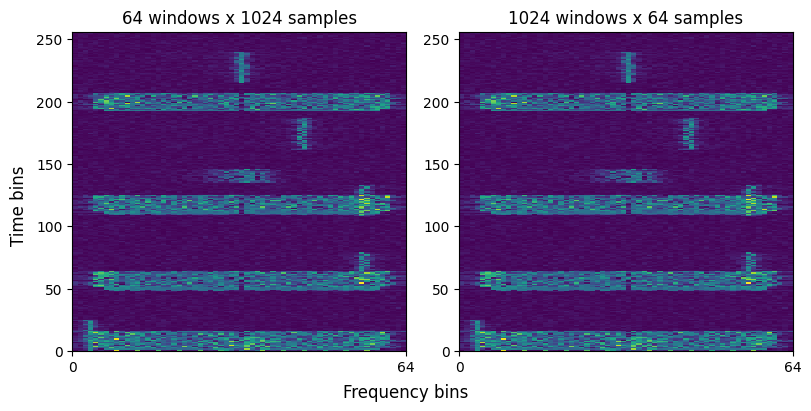

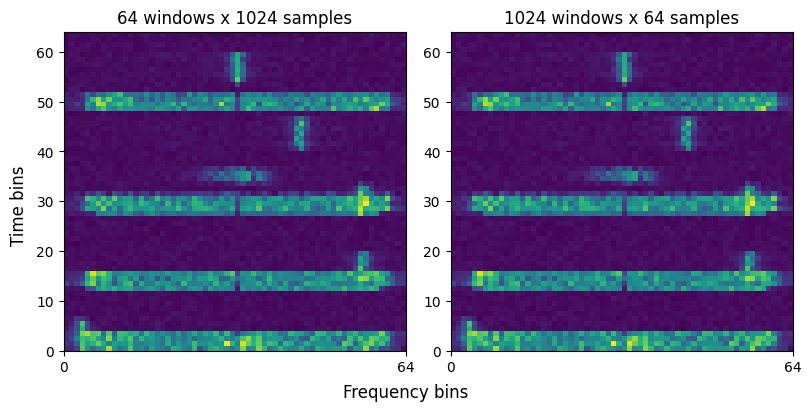

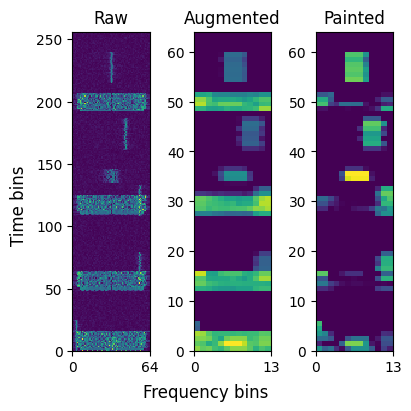

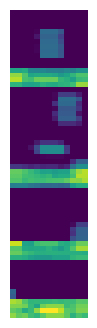

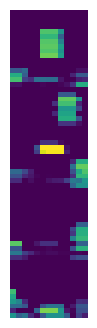

In [12]:
classes = ["ZBW"]
snr = 15

spectrum_painting_options = sp_training.SpectrumPaintingTrainingOptions(
    downsample_resolution=64,
    k=3,
    l=16,
    d=4
)

high_freq_resolution_spec = sp_data.load_spectrograms(data_dir="data/numpy",
                                                      classes=classes,
                                                      snr_list=[snr],
                                                      windows_per_spectrogram=256,
                                                      window_length=256,
                                                      nfft=64).get(snr)[0].values

high_time_resolution_spec = sp_data.load_spectrograms(data_dir="data/numpy",
                                                      classes=classes,
                                                      snr_list=[snr],
                                                      windows_per_spectrogram=256,
                                                      window_length=256,
                                                      nfft=64).get(snr)[0].values

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), constrained_layout=True)


def plot_spectrogram(spectrogram: npt.NDArray, index: int, name: str):
    plt.subplot(1, 2, index)
    plt.pcolormesh(spectrogram, cmap='viridis')
    plt.title(name)
    plt.xticks((0, spectrogram.shape[1]))
    plt.xticks()


plot_spectrogram(high_freq_resolution_spec, 1, "64 windows x 1024 samples")
plot_spectrogram(high_time_resolution_spec, 2, "1024 windows x 64 samples")

fig.supxlabel("Frequency bins")
fig.supylabel("Time bins")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), constrained_layout=True)

plot_spectrogram(downsample_spectrogram(high_freq_resolution_spec, 64), 1, "64 windows x 1024 samples")
plot_spectrogram(downsample_spectrogram(high_time_resolution_spec, 64), 2, "1024 windows x 64 samples")

fig.supxlabel("Frequency bins")
fig.supylabel("Time bins")
plt.show()

spec = sp_data.load_spectrograms(data_dir="data/numpy",
                                 classes=classes,
                                 snr_list=[snr],
                                 windows_per_spectrogram=256,
                                 window_length=256,
                                 nfft=64).get(snr)[0].values

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(4, 4), constrained_layout=True)


def plot_spectrogram(spectrogram: npt.NDArray, index: int, name: str):
    plt.subplot(1, 3, index)
    plt.pcolormesh(spectrogram, cmap='viridis')
    plt.title(name)
    plt.xticks((0, spectrogram.shape[1]))
    plt.xticks()


plot_spectrogram(spec.clip(max=0.04), index=1, name="Raw")

downsampled = downsample_spectrogram(spectrogram=spec, resolution=64)

augmented = augment_spectrogram(spectrogram=downsampled, k=3, l=16, d=4)
plot_spectrogram(augmented, index=2, name="Augmented")

painted = paint_spectrogram(downsampled, augmented)
plot_spectrogram(painted, index=3, name="Painted")

# fig.tight_layout()
fig.supxlabel("Frequency bins")
fig.supylabel("Time bins")
plt.show()

plt.figure(figsize=(1, 4))
plt.pcolormesh(augmented, cmap='viridis')
plt.axis("off")
plt.yticks(None)
plt.show()

plt.figure(figsize=(1, 4))
plt.pcolormesh(painted, cmap='viridis')
plt.axis("off")
plt.yticks(None)
plt.show()

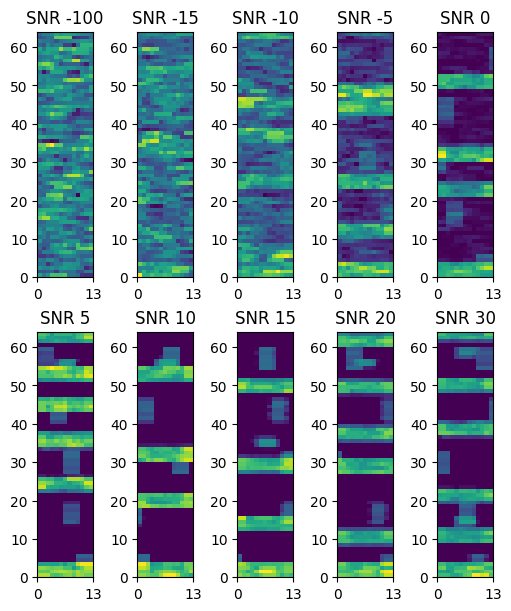

In [13]:
snr_list = [-100, -15, -10, -5, 0, 5, 10, 15, 20, 30]

spectrogram = sp_data.load_spectrograms(data_dir="data/numpy",
                                        classes=["ZBW"],
                                        snr_list=snr_list,
                                        windows_per_spectrogram=256,
                                        window_length=256,
                                        nfft=64)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(5, 6), constrained_layout=True)


def plot_spectrogram(spectrogram: npt.NDArray, index: int, name: str):
    plt.subplot(2, 5, index)
    plt.pcolormesh(spectrogram, cmap='viridis')
    plt.title(name)
    plt.xticks((0, spectrogram.shape[1]))
    plt.xticks()


for i, snr in enumerate(snr_list):
    spec = spectrogram[snr][0].values

    downsampled = downsample_spectrogram(spectrogram=spec, resolution=64)
    augmented = augment_spectrogram(spectrogram=downsampled, k=3, l=16, d=4)

    plot_spectrogram(augmented, i + 1, f"SNR {snr}")

# Read the results and create plots from notebook_spectrum_painting

In [14]:
file_name = "results-final.json"
results: List[Result]

with open(f"output/{file_name}", "r") as f:
    results = json.load(f)["results"]
    results = [Result.from_dict(r) for r in results]

Full model


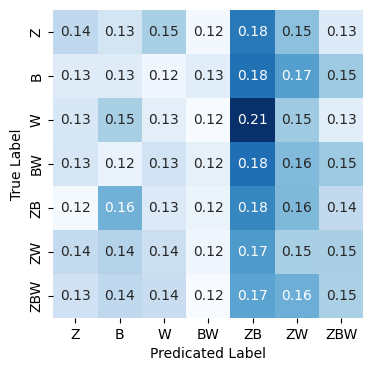

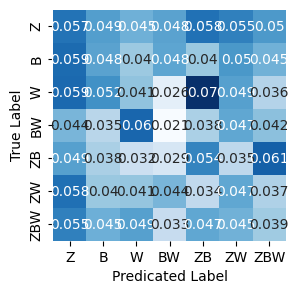

Lite model


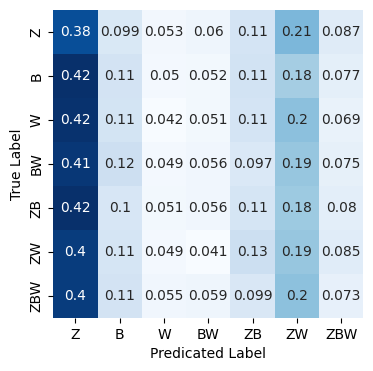

Lite model (no quantization)


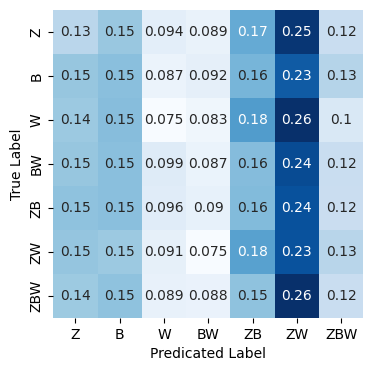

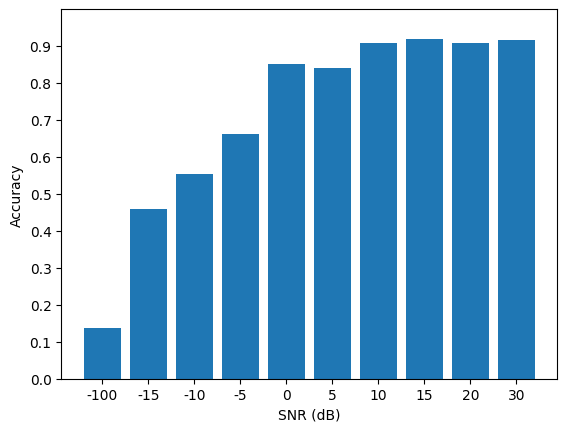

SNR -100
Accuracy = 0.1382213812677389


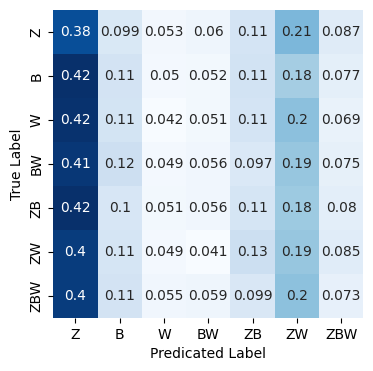

SNR -15
Accuracy = 0.4593713865237044


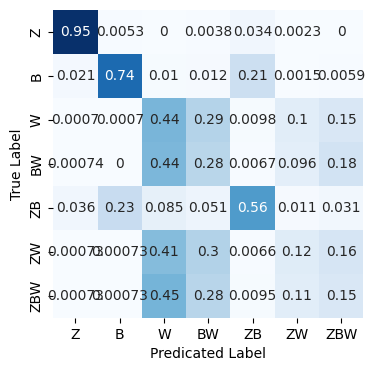

SNR -10
Accuracy = 0.5539262062440871


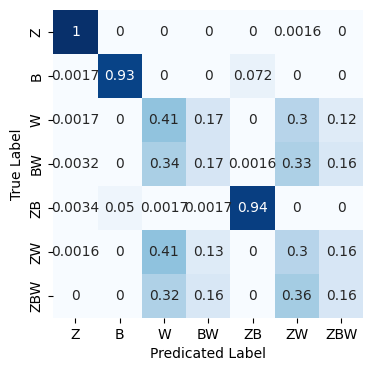

SNR -5
Accuracy = 0.6613055818353831


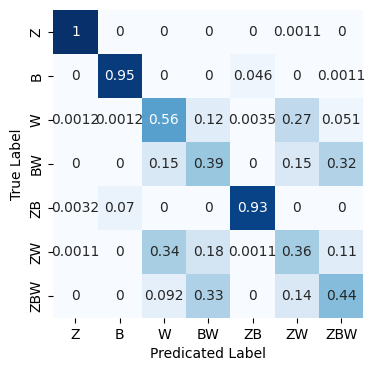

SNR 0
Accuracy = 0.8505203405865658


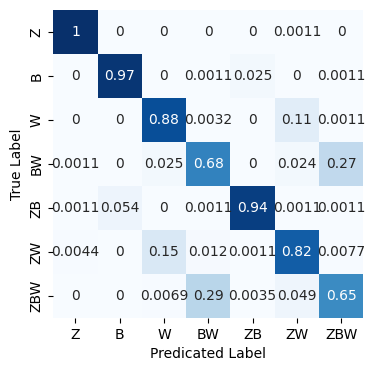

SNR 5
Accuracy = 0.8401135288552507


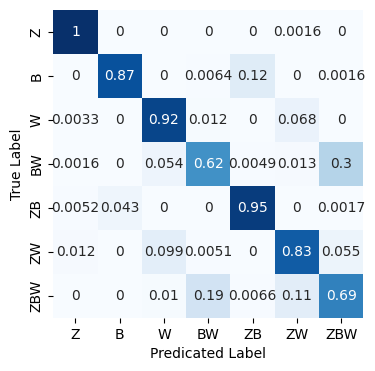

SNR 10
Accuracy = 0.9091769157994324


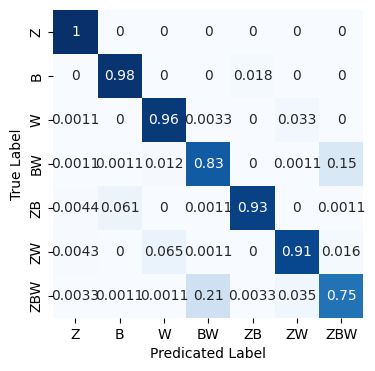

SNR 15
Accuracy = 0.9195837275307474


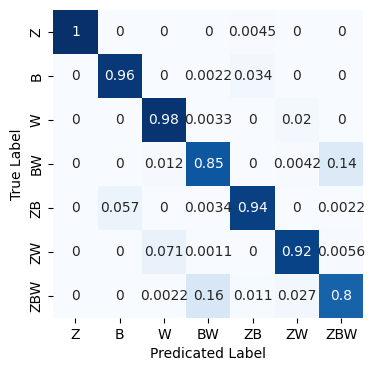

SNR 20
Accuracy = 0.9075212866603595


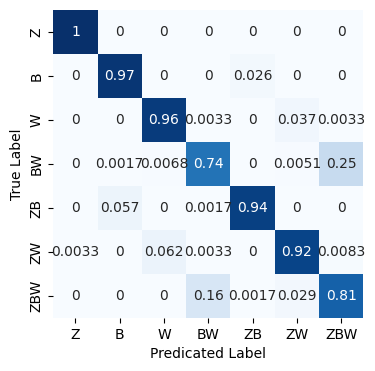

SNR 30
Accuracy = 0.9157994323557237


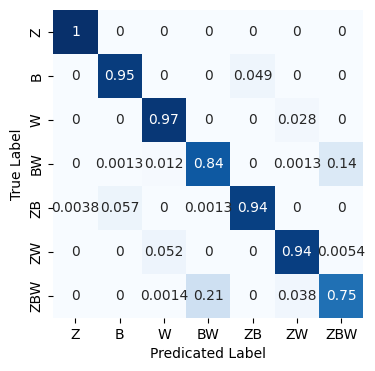

In [17]:
def concat(lists: List) -> List:
    output = []

    for l in lists:
        output.extend(l)

    return output


def calc_accuracy(y_test, predictions) -> float:
    return np.mean(np.asarray(y_test) == np.asarray(predictions))


results_without_outliers = []

# Remove the outliers from the results where the lite accuracy was
# much lower than the full model. There is some problem
# when converting to a Lite model where the accuracy drops significantly.
# It is completely random and doesn't happen very often.
for result in results:
    no_outliers = Result(snr=result.snr,
                         label_names=result.label_names,
                         full_model_labels=[],
                         full_model_predictions=[],

                         lite_model_labels=[],
                         lite_model_predictions=[],
                         lite_model_size=result.lite_model_size,

                         lite_model_no_quant_labels=[],
                         lite_model_no_quant_predictions=[],
                         lite_no_quant_model_size=result.lite_no_quant_model_size)

    for i in range(len(result.full_model_predictions)):
        full_model_avg_accuracy = calc_accuracy(result.full_model_labels, result.full_model_predictions)

        lite_model_avg_accuracy = calc_accuracy(result.lite_model_labels[i], result.lite_model_predictions[i])

        if full_model_avg_accuracy - lite_model_avg_accuracy < 0.1:
            no_outliers.full_model_labels.append(result.full_model_labels[i])
            no_outliers.full_model_predictions.append(result.full_model_predictions[i])

            no_outliers.lite_model_labels.append(result.lite_model_labels[i])
            no_outliers.lite_model_predictions.append(result.lite_model_predictions[i])

            no_outliers.lite_model_no_quant_labels.append(result.lite_model_no_quant_labels[i])
            no_outliers.lite_model_no_quant_predictions.append(result.lite_model_no_quant_predictions[i])

    results_without_outliers.append(no_outliers)

confusion_matrix_snr = -100
confusion_matrix_result: Result = list(filter(lambda r: r.snr == confusion_matrix_snr, results_without_outliers))[0]


def plot_confusion_matrix(y_predictions,
                          y_test,
                          label_names: List[str]):
    cm = confusion_matrix(y_test, y_predictions)
    cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])

    plt.figure(figsize=(4, 4))
    plot = heatmap(cm, xticklabels=label_names, yticklabels=label_names, annot=True, cmap='Blues', cbar=False)
    plot.get_figure()
    plt.ylabel('True Label')
    plt.xlabel('Predicated Label')
    plt.show()


def plot_confusion_matrix_standard_deviation(y_predictions: List[List[int]],
                                             y_test: List[List[int]],
                                             label_names: List[str]):
    cms = []

    for i in range(len(y_predictions)):
        cm = confusion_matrix(y_test[i], y_predictions[i])
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
        cms.append(cm)

    plt.figure(figsize=(3, 3))
    heatmap(np.std(cms, axis=0), cmap='Blues', annot=True, xticklabels=label_names, yticklabels=label_names,
                    cbar=False)
    plt.ylabel('True Label')
    plt.xlabel('Predicated Label')
    plt.show()


print("Full model")
plot_confusion_matrix(concat(confusion_matrix_result.full_model_predictions),
                      concat(confusion_matrix_result.full_model_labels),
                      confusion_matrix_result.label_names)

plot_confusion_matrix_standard_deviation(confusion_matrix_result.full_model_predictions,
                                         confusion_matrix_result.full_model_labels,
                                         confusion_matrix_result.label_names)

print("Lite model")
plot_confusion_matrix(concat(confusion_matrix_result.lite_model_predictions),
                      concat(confusion_matrix_result.lite_model_labels),
                      confusion_matrix_result.label_names)

print("Lite model (no quantization)")
plot_confusion_matrix(concat(confusion_matrix_result.lite_model_no_quant_predictions),
                      concat(confusion_matrix_result.lite_model_no_quant_labels),
                      confusion_matrix_result.label_names)

y_full_accuracy = []
y_lite_accuracy = []
x_snr = []

for result in results_without_outliers:
    x_snr.append(result.snr)

    y_test = concat(result.lite_model_labels)
    predictions = concat(result.lite_model_predictions)

    full_model_avg_accuracy = calc_accuracy(result.full_model_labels, result.full_model_predictions)
    y_full_accuracy.append(full_model_avg_accuracy)

    lite_model_avg_accuracy = calc_accuracy(result.lite_model_labels, result.lite_model_predictions)
    y_lite_accuracy.append(lite_model_avg_accuracy)

plt.bar(x=range(len(x_snr)),
        height=y_lite_accuracy,
        tick_label=x_snr)
plt.yticks(np.arange(0, 1, step=0.1))
plt.ylim((0, 1))
plt.ylabel("Accuracy")
plt.xlabel("SNR (dB)")
plt.show()

# Plot all confusion matrices
for (i, result) in enumerate(results_without_outliers):
    snr = result.snr
    print(f"SNR {snr}")

    y_test = concat(result.lite_model_labels)
    predictions = concat(result.lite_model_predictions)

    avg_accuracy = calc_accuracy(y_test, predictions)
    print(f"Accuracy = {avg_accuracy}")

    plot_confusion_matrix(predictions, y_test, result.label_names)
    # plot_confusion_matrix_standard_deviation(result.full_model_predictions, result.full_model_labels, result.label_names)